In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use('seaborn')
import seaborn as sns

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, plot_roc_curve, balanced_accuracy_score, r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV

In [3]:
train = pd.read_csv('data_train.csv')
test = pd.read_csv('data_test.csv')

In [4]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,0,77516,0,13,0,0,0,0,0,2174,0,40,0,0
1,50,1,83311,0,13,1,1,1,0,0,0,0,13,0,0
2,38,2,215646,1,9,2,2,0,0,0,0,0,40,0,0
3,53,2,234721,2,7,1,2,1,1,0,0,0,40,0,0
4,28,2,338409,0,13,1,3,2,1,1,0,0,40,1,0


### Our first RF model with default parameters (and random_state = 42)

In [5]:
# Train
X_train = train.drop(['income'], axis=1)
y_train = train['income']
# Test
X_test = test.drop(['income'], axis=1)
y_test = test['income']

Accuracy: 0.8529574350469873
Mean Cross-Validation Scores: 0.8581742857379947


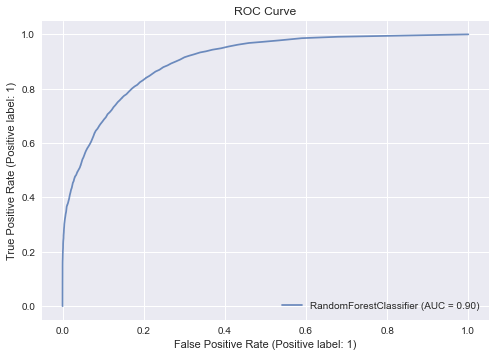

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     12435
           1       0.73      0.61      0.66      3846

    accuracy                           0.85     16281
   macro avg       0.81      0.77      0.78     16281
weighted avg       0.85      0.85      0.85     16281

Matthews coefficient: 0.5714334077189942


In [18]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred=rfc.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred))
scores = cross_val_score(rfc, X_train, y_train, cv=10, scoring = "accuracy")
print("Mean Cross-Validation Scores:", scores.mean())
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=ax, alpha=0.8)
plt.title('ROC Curve')
plt.show()
print(classification_report(y_test,y_pred))
print("Matthews coefficient:", matthews_corrcoef(y_test, y_pred))

In [7]:
score = rfc.score(X_train, y_train)
print("Evaluating the model on the training set yields an accuracy of {}%".format(score*100))
score=rfc.score(X_test, y_test)
print("Evaluating the model on the testing set yields an accuracy of {:.2f}%".format(score*100))

Evaluating the model on the training set yields an accuracy of 99.99692884125182%
Evaluating the model on the testing set yields an accuracy of 85.30%


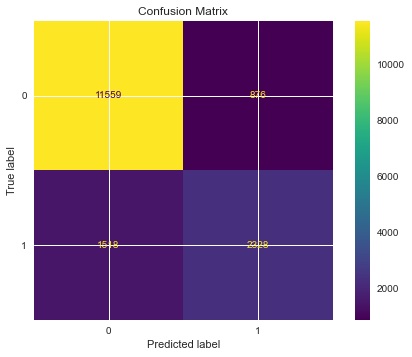

In [8]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rfc, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()  

<AxesSubplot:xlabel='feature'>

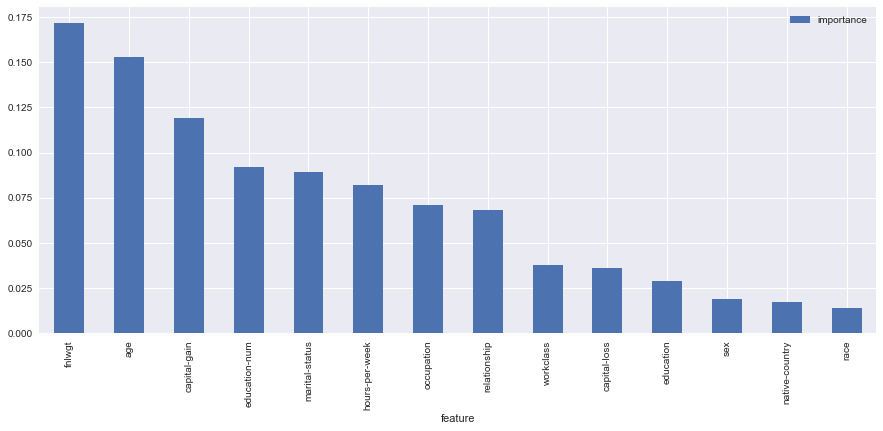

In [9]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rfc.feature_importances_,3)})
importances1 = importances.sort_values('importance',ascending=False).set_index('feature')
importances1.plot(kind='bar',figsize=(15,6))

### Let's fine tune the hyperparameters

In [23]:
def single_grid_search(X_train, y_train, n_kfolds):
    """
    Performs a grid search using the training set given.
    Prints the best score and best parameters.
    Returns the best parameters in a dictionnary.
    """
    rfc = RandomForestClassifier()
    kf = KFold(n_splits=n_kfolds)
    
    # Setting all the parameters we want to test
    max_features=np.arange(10,40,10).tolist()
    n_estimators=np.arange(100,140,10).tolist()
    min_samples_leaf=np.arange(2,12,2).tolist()

    param_grid=dict(n_estimators=n_estimators,max_features=max_features,min_samples_leaf=min_samples_leaf)

    grid = GridSearchCV(estimator = rfc,
                            param_grid = param_grid,
                            scoring = 'accuracy', 
                            cv = kf, 
                            verbose = 2,
                            n_jobs = -1 
                            )
    gres=grid.fit(X_train_dummies,y_train_dummies)
    print("Best score",gres.best_score_)
    print("Best parameters",gres.best_params_)
    return gres.best_params_

In [11]:
def optimized_model(X_train:pd.DataFrame, 
                    y_train:pd.DataFrame, 
                    X_test:pd.DataFrame,
                    y_test:pd.DataFrame, 
                    max_features:int, 
                    min_samples_leaf:int, 
                    n_estimators:int, 
                    random_state=42):
    """
    Gives different score metrics for a RandomForestClassifier model.
    Plots the confusion matrix.
    """
    rfc = RandomForestClassifier(
        max_features = max_features, 
        min_samples_leaf = min_samples_leaf, 
        n_estimators = n_estimators, 
        random_state = random_state)
    rfc.fit(X_train, y_train)
    y_pred=rfc.predict(X_test)
    print("Accuracy:",accuracy_score(y_test, y_pred))
    scores = cross_val_score(rfc, X_train, y_train, cv=10, scoring = "accuracy")
    print("Mean CV Score:", scores.mean())
    print("Matthews correlation coefficient:", matthews_corrcoef(y_test, y_pred))
    print(classification_report(y_test,y_pred))
    plot_confusion_matrix(rfc, X_test, y_test)
    plt.title('Confusion Matrix')
    plt.show() 

In [27]:
result = single_grid_search(X_train, y_train, 3)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best score 0.8636714006220783
Best parameters {'max_features': 10, 'min_samples_leaf': 2, 'n_estimators': 120}


Accuracy: 0.8559056569006818
Mean CV Score: 0.8608461533238936
Matthews correlation coefficient: 0.5790176709927526
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     12435
           1       0.74      0.61      0.67      3846

    accuracy                           0.86     16281
   macro avg       0.81      0.77      0.79     16281
weighted avg       0.85      0.86      0.85     16281



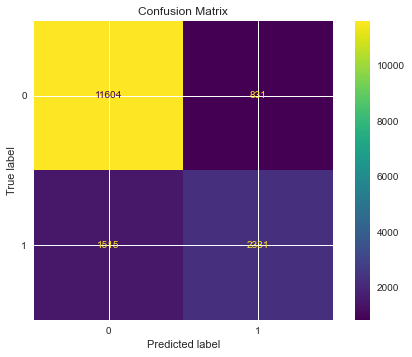

In [28]:
optimized_model(X_train, y_train, X_test, y_test, result.get('max_features'), result.get('min_samples_leaf'), result.get('n_estimators'))

In [ ]:
score = rfc.score(X_train, y_train)
print("Evaluating the model on the training set yields an accuracy of {}%".format(score*100))
score=rfc.score(X_test, y_test)
print("Evaluating the model on the testing set yields an accuracy of {:.2f}%".format(score*100))

One-Hot Encoding

In [19]:
# One-Hot encoding
columns_to_dummies = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship', 
    'race', 
    'sex', 
    'native-country']
train_dummies = pd.get_dummies(train, columns=columns_to_dummies)
test_dummies = pd.get_dummies(test, columns=columns_to_dummies)
# Add one more column ['native-country_41'] to the test set, so it matches the columns of the train set
test_dummies['native-country_41'] = 0

In [20]:
# Train with dummies
X_train_dummies = train_dummies.drop(['income'], axis=1)
y_train_dummies = train_dummies['income']
# Test with dummies
X_test_dummies = test_dummies.drop(['income'], axis=1)
y_test_dummies = test_dummies['income']

In [22]:
result_dummies = single_grid_search(X_train_dummies, y_train_dummies, 3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score 0.8633642064585416
Best parameters {'max_features': 10, 'min_samples_leaf': 2, 'n_estimators': 110}


Accuracy: 0.8646274798845279
Mean CV Score: 0.8643779340509459
Matthews correlation coefficient: 0.6036647374402209
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     12435
           1       0.76      0.62      0.68      3846

    accuracy                           0.86     16281
   macro avg       0.83      0.78      0.80     16281
weighted avg       0.86      0.86      0.86     16281



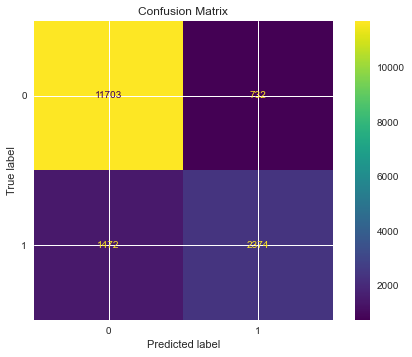

In [24]:
optimized_model(X_train_dummies, y_train_dummies, X_test_dummies, y_test_dummies, result_dummies.get('max_features'), result_dummies.get('min_samples_leaf'), result_dummies.get('n_estimators'))